In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In here firstly we load our data and then we plan on what to do next as to what out expectations from the data is.

In [2]:
train_df = pd.read_csv("tweets_21.csv")
test_df = pd.read_csv("tweets_labeled.csv")

In [3]:
train_df.head()

,tweet_id,tweet,date
0,1344798002490314752,Kardesim (12) sevdigi cocuga 00:00 da ilan-i a...,2021-01-01 03:10:03
1,1344799527673470977,Bu yılbaşı da saat tam 00:00'da swni seviyorum...,2021-01-01 03:16:07
2,1344799907719348226,tam 00.00da naptınız ben her yıl tam bu vakit ...,2021-01-01 03:17:37
3,1344800782802165762,00:00'da havai fişek gösterisi yapıldı tam dib...,2021-01-01 03:21:06
4,1344805589990453249,31 aralık saat 00.00 da yeni yılımızı kutlayan...,2021-01-01 03:40:12


In [4]:
test_df.head()

,tweet_id,tweet,date,label
0,1606767075984375808,Berk Ali (kedim) seni çok özledim. Ölmek için ...,2022-12-24 21:41:37+00:00,1
1,1537178207677448193,"Yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-15 21:00:18+00:00,1
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-13 21:21:36+00:00,1
3,1495413883166760960,"Öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 15:03:47+00:00,1
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 20:22:32+00:00,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13272 entries, 0 to 13271
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  13272 non-null  int64 
 1   tweet     13272 non-null  object
 2   date      13272 non-null  object
dtypes: int64(1), object(2)
memory usage: 311.2+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  12960 non-null  int64 
 1   tweet     12959 non-null  object
 2   date      12960 non-null  object
 3   label     12960 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 405.1+ KB


## Data Cleaning and Future Extraction

Now we do a cleaning process. This celaning in the fature will assure out models to be optimized as well as to make EDA easy and detailed.

#### Cleaning
1. localize and seperate "date" column for EDA
2. change all tweets to lower case
3. emoticon classification
4. replace punctuations with space 
5. replace special characters and number with space
6. remove tweets with one word
7. tokenize the tweet column
8. remove stop words from the dataset

##### 1. localize and seperate "date" column for EDA

In [7]:
test_df.isna().sum()

tweet_id    0
tweet       1
date        0
label       0
dtype: int64

In [8]:
train_df.isna().sum()

tweet_id    0
tweet       0
date        0
dtype: int64

In [9]:
test_df["date"] = pd.to_datetime(test_df["date"])
test_df['date'] = test_df['date'].dt.tz_localize(None)
train_df["date"] = pd.to_datetime(train_df["date"])
train_df['date'] = test_df['date'].dt.tz_localize(None)

In [10]:
test_df["month"] = test_df["date"].dt.month_name()
train_df["month"] = train_df["date"].dt.month_name()

In [11]:
def replace_month_names(df, column_name):
    month_translation = {
        'December': 'Aralık',
        'January': 'Ocak',
        'February': 'Şubat',
        'March': 'Mart',
        'April': 'Nisan',
        'May': 'Mayıs',
        'June': 'Haziran',
        'July': 'Temmuz',
        'August': 'Ağustos',
        'September': 'Eylül',
        'October': 'Ekim',
        'November': 'Kasım'
    }
    df[column_name] = df[column_name].replace(month_translation)
    return df

test_df = replace_month_names(test_df, 'month')
train_df = replace_month_names(train_df, 'month')

In [12]:
seasons = {'Ocak': 'Kış',
           'Şubat': 'Kış',
           'Mart': 'İlkbahar',
           'Nisan': 'İlkbahar',
           'Mayıs': 'İlkbahar',
           'Haziran': 'Yaz',
           'Temmuz': 'Yaz',
           'Ağustos': 'Yaz',
           'Eylül': 'Sonbahar',
           'Ekim': 'Sonbahar',
           'Kasım': 'Sonbahar',
           'Aralık': 'Kış'}
test_df['seasons'] = test_df['month'].map(seasons)
train_df['seasons'] = train_df['month'].map(seasons)

In [13]:
test_df = test_df.dropna()
train_df = train_df.dropna()

In [14]:
test_df["days"] = [date.strftime('%A') for date in test_df["date"]]
train_df["days"] = [date.strftime('%A') for date in train_df["date"]]

In [15]:
def replace_day_names(df,column_name):
    day_translation = {"Monday" : "Pazartesi",
                                 "Tuesday" : "Salı",
                                 "Wednesday" : "Çarşamba",
                                 "Thursday": "Perşembe",
                                 "Friday" : "Cuma",
                                 "Saturday" : "Cumartesi",
                                 "Sunday": "Pazar"}
    df[column_name] = df[column_name].replace(day_translation)
    return df

test_df = replace_day_names(test_df,"days")
train_df = replace_day_names(train_df,"days")

In [16]:
test_df['hour'] = test_df['date'].dt.hour
test_df['4hour_interval'] = (test_df['hour'] // 2) * 2
interval = {0: '0-2',
            2: '2-4',
            4: '4-6',
            6: '6-8',
            8: '8-10',
            10: '10-12',
            12: '12-14',
            14: '14-16',
            16: '16-18',
            18: '18-20',
            20: '20-22',
            22: '22-24'
            }

train_df['hour'] = train_df['date'].dt.hour
train_df['4hour_interval'] = (train_df['hour'] // 2) * 2
interval = {0: '0-2',
            2: '2-4',
            4: '4-6',
            6: '6-8',
            8: '8-10',
            10: '10-12',
            12: '12-14',
            14: '14-16',
            16: '16-18',
            18: '18-20',
            20: '20-22',
            22: '22-24'
            }

In [17]:
def replace_hour_interval(df,column_name):
    hour_tranlation = { "0-2": "22-02",
                        "22-24": "22-02",
                        "2-4": "02-06",
                        "4-6": "02-06",
                        "6-8": "06-10",
                        "8-10": "06-10",
                        "10-12": "10-14",
                        "12-14": "10-14",
                        "14-16": "14-18",
                        "16-18": "14-18",
                        "18-20": "18-22",
                        "20-22": "18-22"}
    df[column_name] = df[column_name].replace(hour_tranlation)
    return df

test_df = replace_hour_interval(test_df,"4hour_interval")
train_df = replace_hour_interval(train_df,"4hour_interval")

In [18]:
test_df.drop(["4hour_interval", "hour"], axis=1, inplace=True)
train_df.drop(["4hour_interval", "hour"], axis=1, inplace=True)

In [19]:
test_df.head()

,tweet_id,tweet,date,label,month,seasons,days
0,1606767075984375808,Berk Ali (kedim) seni çok özledim. Ölmek için ...,2022-12-24 21:41:37,1,Aralık,Kış,Cumartesi
1,1537178207677448193,"Yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-15 21:00:18,1,Haziran,Yaz,Çarşamba
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-13 21:21:36,1,Haziran,Yaz,Pazartesi
3,1495413883166760960,"Öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 15:03:47,1,Şubat,Kış,Pazar
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 20:22:32,1,Şubat,Kış,Pazar


In [20]:
train_df.head()

,tweet_id,tweet,date,month,seasons,days
0,1344798002490314752,Kardesim (12) sevdigi cocuga 00:00 da ilan-i a...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi
1,1344799527673470977,Bu yılbaşı da saat tam 00:00'da swni seviyorum...,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba
2,1344799907719348226,tam 00.00da naptınız ben her yıl tam bu vakit ...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi
3,1344800782802165762,00:00'da havai fişek gösterisi yapıldı tam dib...,2022-02-20 15:03:47,Şubat,Kış,Pazar
4,1344805589990453249,31 aralık saat 00.00 da yeni yılımızı kutlayan...,2022-02-06 20:22:32,Şubat,Kış,Pazar


In [21]:
combined_df = pd.concat([train_df,test_df,], ignore_index = True)
combined_df.head()

,tweet_id,tweet,date,month,seasons,days,label
0,1344798002490314752,Kardesim (12) sevdigi cocuga 00:00 da ilan-i a...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi,NaN
1,1344799527673470977,Bu yılbaşı da saat tam 00:00'da swni seviyorum...,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba,NaN
2,1344799907719348226,tam 00.00da naptınız ben her yıl tam bu vakit ...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi,NaN
3,1344800782802165762,00:00'da havai fişek gösterisi yapıldı tam dib...,2022-02-20 15:03:47,Şubat,Kış,Pazar,NaN
4,1344805589990453249,31 aralık saat 00.00 da yeni yılımızı kutlayan...,2022-02-06 20:22:32,Şubat,Kış,Pazar,NaN


In [22]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25919 entries, 0 to 25918
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tweet_id  25919 non-null  int64         
 1   tweet     25919 non-null  object        
 2   date      25919 non-null  datetime64[ns]
 3   month     25919 non-null  object        
 4   seasons   25919 non-null  object        
 5   days      25919 non-null  object        
 6   label     12959 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.4+ MB


##### 2. change all tweets to lower case

In [23]:
#combined_df["tweet"] = combined_df["tweet"].astype(str)
train_df["tweet"] = train_df["tweet"].astype(str)
test_df["tweet"] = test_df["tweet"].astype(str)

In [24]:
#combined_df["tweet"] = combined_df["tweet"].apply(lambda str1: str1.lower())
train_df["tweet"] = train_df["tweet"].apply(lambda str2: str2.lower())
test_df["tweet"] = test_df["tweet"].apply(lambda str3: str3.lower())

##### 3. emoticon classification

In [25]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}

In [26]:
def classification(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [27]:
#combined_df["tweet"] = combined_df["tweet"].apply(lambda x: classification(x,emoticon_dict))
train_df["tweet"] = train_df["tweet"].apply(lambda x: classification(x,emoticon_dict))
test_df["tweet"] = test_df["tweet"].apply(lambda x: classification(x,emoticon_dict))

##### 4. replace punctuations with space

In [28]:
#combined_df["tweet"] = combined_df["tweet"].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
train_df["tweet"] = train_df["tweet"].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
test_df["tweet"] = test_df["tweet"].apply(lambda x: re.sub(r'[^\w\s]',' ',x))

##### 5. replace special characters and number with space

In [29]:
#combined_df["tweet"] = combined_df["tweet"].apply(lambda x: re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]|\d+',' ',x))
train_df["tweet"] = train_df["tweet"].apply(lambda x: re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]|\d+',' ',x))
test_df["tweet"] = test_df["tweet"].apply(lambda x: re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]|\d+',' ',x))

In [30]:
train_df.head()

,tweet_id,tweet,date,month,seasons,days
0,1344798002490314752,kardesim sevdigi cocuga da ilan i a...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi
1,1344799527673470977,bu yılbaşı da saat tam da swni seviyorum...,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba
2,1344799907719348226,tam da naptınız ben her yıl tam bu vakit ...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi
3,1344800782802165762,da havai fişek gösterisi yapıldı tam dib...,2022-02-20 15:03:47,Şubat,Kış,Pazar
4,1344805589990453249,aralık saat da yeni yılımızı kutlayan...,2022-02-06 20:22:32,Şubat,Kış,Pazar


##### 6. tokenize the tweet column

In [31]:
#combined_df["tweet_token"] = combined_df["tweet"].apply(lambda x: word_tokenize(x))
train_df["tweet_token"] = train_df["tweet"].apply(lambda x: word_tokenize(x))
test_df["tweet_token"] = test_df["tweet"].apply(lambda x: word_tokenize(x))
train_df.head()

,tweet_id,tweet,date,month,seasons,days,tweet_token
0,1344798002490314752,kardesim sevdigi cocuga da ilan i a...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi,"[kardesim, sevdigi, cocuga, da, ilan, i, ask, ..."
1,1344799527673470977,bu yılbaşı da saat tam da swni seviyorum...,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba,"[bu, yılbaşı, da, saat, tam, da, swni, seviyor..."
2,1344799907719348226,tam da naptınız ben her yıl tam bu vakit ...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi,"[tam, da, naptınız, ben, her, yıl, tam, bu, va..."
3,1344800782802165762,da havai fişek gösterisi yapıldı tam dib...,2022-02-20 15:03:47,Şubat,Kış,Pazar,"[da, havai, fişek, gösterisi, yapıldı, tam, di..."
4,1344805589990453249,aralık saat da yeni yılımızı kutlayan...,2022-02-06 20:22:32,Şubat,Kış,Pazar,"[aralık, saat, da, yeni, yılımızı, kutlayan, b..."


#### can be used for the same job
def tokenize(df,column):

    for i,row in df.iterrows():
        text = row[column]
        text_token = word_tokenize(text)
    return df
    
combined_df["tweet_token"] = combined_df["tweet_token"]
tokenize(combined_df,"tweet_token")

##### 7. remove tweets with one word

In [32]:
#combined_df["tweet"] = combined_df["tweet"].apply(lambda x: "".join([w for w in x.split() if len(w)>1]))
train_df["tweet"] = train_df["tweet"].apply(lambda x: "".join([w for w in x.split() if len(w)>1]))
test_df["tweet"] = test_df["tweet"].apply(lambda x: "".join([w for w in x.split() if len(w)>1]))

In [33]:
#combined_df["tweet_token"] = combined_df["tweet_token"].apply(lambda tokens: [token for token in tokens if len(token) > 1])
train_df["tweet_token"] = train_df["tweet_token"].apply(lambda tokens: [token for token in tokens if len(token) > 1])
test_df["tweet_token"] = test_df["tweet_token"].apply(lambda tokens: [token for token in tokens if len(token) > 1])

###### can be used for the same job
def filter_single_chars(tokens):
    return [token for token in tokens if len(token) > 1]

combined_df["tweet_token"] = combined_df["tweet_token"].apply(filter_single_chars)

print(combined_df["tweet_token"].head())


In [34]:
train_df.head()

,tweet_id,tweet,date,month,seasons,days,tweet_token
0,1344798002490314752,kardesimsevdigicocugadailanasketmiscocuksimdiy...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi,"[kardesim, sevdigi, cocuga, da, ilan, ask, etm..."
1,1344799527673470977,buyılbaşıdasaattamdaswniseviyorummesajıgelmedi,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba,"[bu, yılbaşı, da, saat, tam, da, swni, seviyor..."
2,1344799907719348226,tamdanaptınızbenheryıltambuvakitdinlediğimşark...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi,"[tam, da, naptınız, ben, her, yıl, tam, bu, va..."
3,1344800782802165762,dahavaifişekgösterisiyapıldıtamdibimizdeancakk...,2022-02-20 15:03:47,Şubat,Kış,Pazar,"[da, havai, fişek, gösterisi, yapıldı, tam, di..."
4,1344805589990453249,aralıksaatdayeniyılımızıkutlayanbirisiyineolma...,2022-02-06 20:22:32,Şubat,Kış,Pazar,"[aralık, saat, da, yeni, yılımızı, kutlayan, b..."


##### 8. remove stop words from the dataset

In [35]:
stop_words = set(stopwords.words("turkish"))
stop_words

{'acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'en',
 'eğer',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'ile',
 'ise',
 'için',
 'kez',
 'ki',
 'kim',
 'mu',
 'mü',
 'mı',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niye',
 'niçin',
 'o',
 'sanki',
 'siz',
 'tüm',
 've',
 'veya',
 'ya',
 'yani',
 'çok',
 'çünkü',
 'şey',
 'şu'}

In [36]:
#combined_df["tweet_token_clean"] = combined_df["tweet_token"].apply(lambda x: [word for word in x if not word in stop_words])
train_df["tweet_token_clean"] = train_df["tweet_token"].apply(lambda x: [word for word in x if not word in stop_words])
test_df["tweet_token_clean"] = test_df["tweet_token"].apply(lambda x: [word for word in x if not word in stop_words])

In [37]:
train_df.head()

,tweet_id,tweet,date,month,seasons,days,tweet_token,tweet_token_clean
0,1344798002490314752,kardesimsevdigicocugadailanasketmiscocuksimdiy...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi,"[kardesim, sevdigi, cocuga, da, ilan, ask, etm...","[kardesim, sevdigi, cocuga, ilan, ask, etmis, ..."
1,1344799527673470977,buyılbaşıdasaattamdaswniseviyorummesajıgelmedi,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba,"[bu, yılbaşı, da, saat, tam, da, swni, seviyor...","[yılbaşı, saat, tam, swni, seviyorum, mesajı, ..."
2,1344799907719348226,tamdanaptınızbenheryıltambuvakitdinlediğimşark...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi,"[tam, da, naptınız, ben, her, yıl, tam, bu, va...","[tam, naptınız, ben, yıl, tam, vakit, dinlediğ..."
3,1344800782802165762,dahavaifişekgösterisiyapıldıtamdibimizdeancakk...,2022-02-20 15:03:47,Şubat,Kış,Pazar,"[da, havai, fişek, gösterisi, yapıldı, tam, di...","[havai, fişek, gösterisi, yapıldı, tam, dibimi..."
4,1344805589990453249,aralıksaatdayeniyılımızıkutlayanbirisiyineolma...,2022-02-06 20:22:32,Şubat,Kış,Pazar,"[aralık, saat, da, yeni, yılımızı, kutlayan, b...","[aralık, saat, yeni, yılımızı, kutlayan, biris..."


In [38]:
test_df.head()

,tweet_id,tweet,date,label,month,seasons,days,tweet_token,tweet_token_clean
0,1606767075984375808,berkalikedimseniçoközledimölmekiçindahaküçücük...,2022-12-24 21:41:37,1,Aralık,Kış,Cumartesi,"[berk, ali, kedim, seni, çok, özledim, ölmek, ...","[berk, ali, kedim, seni, özledim, ölmek, küçüc..."
1,1537178207677448193,yaniöylesineciddiyealacaksınkiyaşamayıyetmişin...,2022-06-15 21:00:18,1,Haziran,Yaz,Çarşamba,"[yani, öylesine, ciddiye, alacaksın, ki, yaşam...","[öylesine, ciddiye, alacaksın, yaşamayı, yetmi..."
2,1536458790802972673,saçlarınıngölgesindeölmeknegüzeldi,2022-06-13 21:21:36,1,Haziran,Yaz,Pazartesi,"[saçlarının, gölgesinde, ölmek, ne, güzeldi]","[saçlarının, gölgesinde, ölmek, güzeldi]"
3,1495413883166760960,öylegüzelbaktınkigözlerimesevmekdeğilölmekgeld...,2022-02-20 15:03:47,1,Şubat,Kış,Pazar,"[öyle, güzel, baktın, ki, gözlerime, sevmek, d...","[öyle, güzel, baktın, gözlerime, sevmek, değil..."
4,1490420667614904334,sevmekbiriiçinölmekdeğilherşeyerağmenyaşayabil...,2022-02-06 20:22:32,1,Şubat,Kış,Pazar,"[sevmek, biri, için, ölmek, değil, her, şeye, ...","[sevmek, ölmek, değil, şeye, rağmen, yaşayabil..."


## Exploratory Data Analysis

In here we do an EDA which will give us insights about our data and will help us to decide if we do it for a client (this part is not eligible for this project) and see the patterns. In here we asked a few questions then we answered them driven from the dataset.

### Questions
1. What is the distribution of labels?
2. What are the most common words/phrases used in tweets?
3. What is the average length of the tweets?
4. Is there a correlation between the length of the tweet's label?
5. What are the most frequent words?
6. What is the most tweet posted month of the year?
7. How does the distribution of labels vary over time (date)?

#### 1. What is the ratio of the positive negative and natural tweets

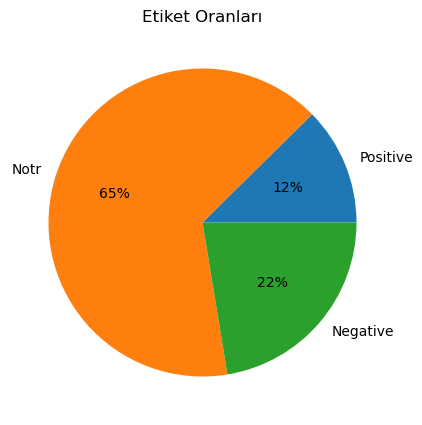

In [39]:
positive = test_df.loc[test_df["label"] == 1].count()[0]
notr = test_df.loc[test_df["label"] == 0].count()[0]
negative = test_df.loc[test_df["label"] == -1].count()[0]

labels_r = ["Positive","Notr","Negative"]

plt.figure(figsize=(8,5),dpi = 100)
plt.pie([positive,notr,negative],labels = labels_r,autopct="%.f%%")
plt.title("Etiket Oranları")
plt.show()

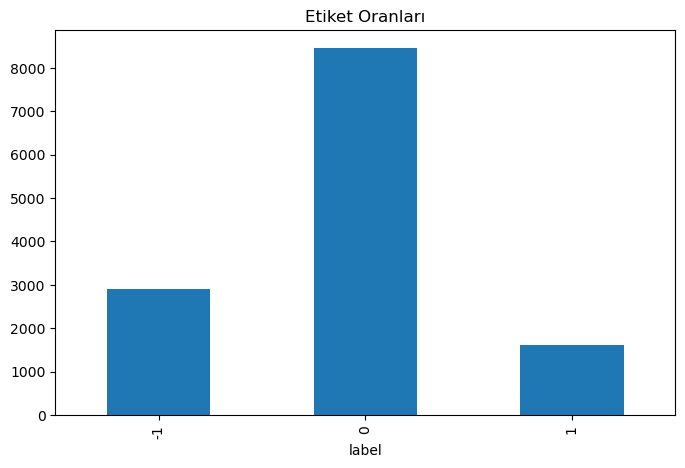

In [40]:
ax = test_df["label"].value_counts().sort_index().plot(kind = "bar",title = "Etiket Oranları",figsize = (8,5))
plt.show()

#### 2. What are the most common words/phrases used in tweets?

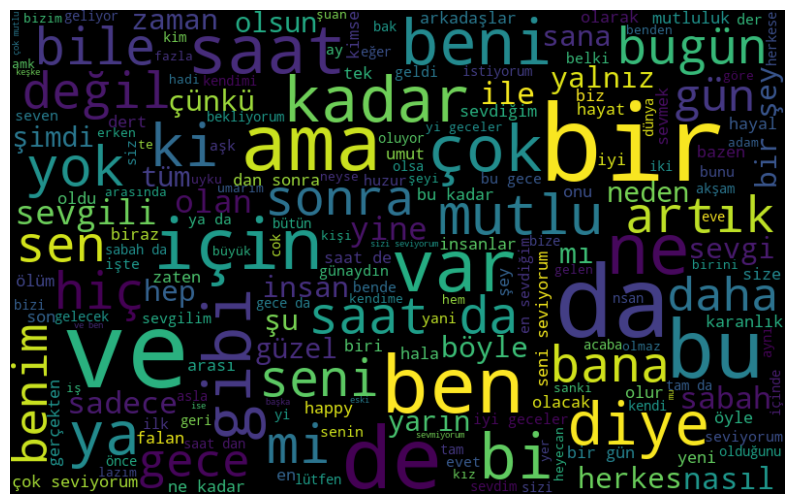

In [42]:
all_words = [word for sublist in train_df["tweet_token"] for word in sublist]
all_words_str = ' '.join(all_words)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_str)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### 3. What is the average length of the tweets?

In [53]:
avr_len = train_df["tweet"].apply(lambda x: len(x))
avr_len.mean()

77.63317901234568

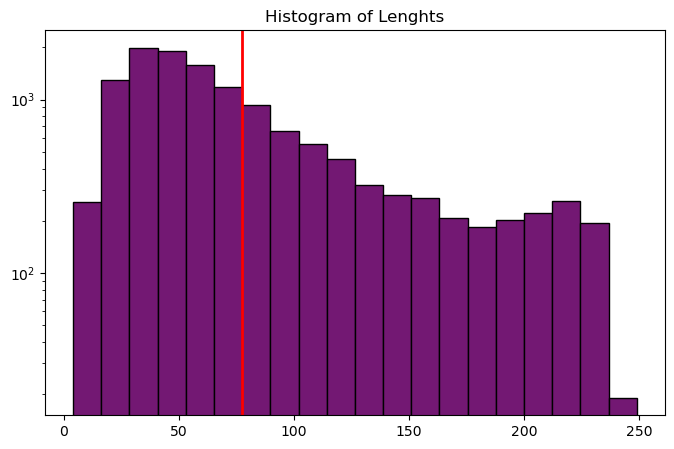

In [54]:
plt.figure(figsize = (8,5),dpi = 100)

plt.hist(avr_len,bins = 20,color = "#731873",edgecolor = "k",log = True)
plt.axvline(avr_len.mean(),color = "r",label = "Mean Lenght",linewidth = 2)

plt.title("Histogram of Lenghts")
plt.show()

#### 4. Is there a correlation between the length of the tweet's label?

In [58]:
train_len = test_df.copy()
train_len["len"] = train_df["tweet"].apply(lambda x: len(x))

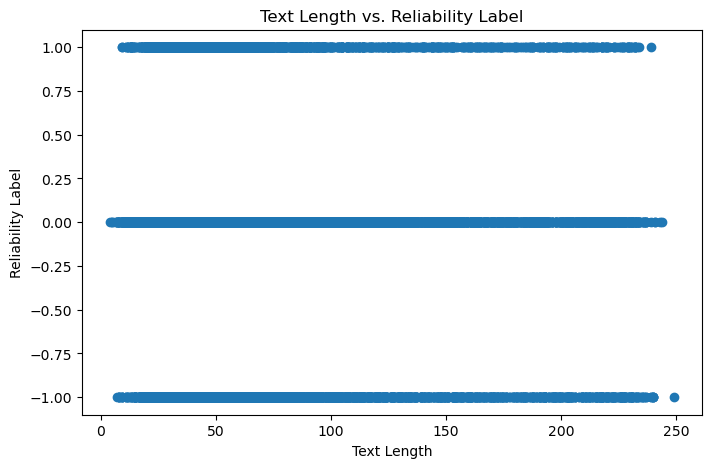

In [59]:
# correlation coefficiency
correlation = np.corrcoef(train_len["len"], train_len["label"])[0, 1]

plt.figure(figsize=(8, 5), dpi=100)
plt.scatter(train_len["len"], train_len["label"])
plt.title("Text Length vs. Reliability Label")
plt.xlabel("Text Length")
plt.ylabel("Reliability Label")
plt.show()

#### 5. What are the most frequent words?

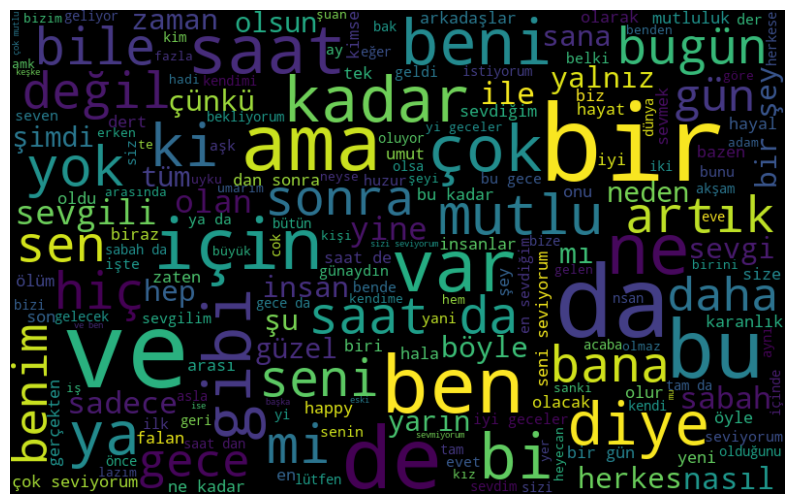

In [60]:
frq = " ".join([word for sublist in train_df["tweet_token"] for word in sublist])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_str)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Another way to do it

all_words = [word for sublist in train_df["tweet_token"] for word in sublist]
all_words_str = ' '.join(all_words)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_str)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### 6. What is the most tweet posted month of the year?

In [65]:
df_month = train_df.copy()
df_month = train_df.groupby('month').size().reset_index(name='count')
df_month

,month,count
0,Aralık,2479
1,Ağustos,1344
2,Ekim,1100
3,Eylül,1104
4,Haziran,718
5,Kasım,1257
6,Mart,929
7,Mayıs,784
8,Nisan,679
9,Ocak,934


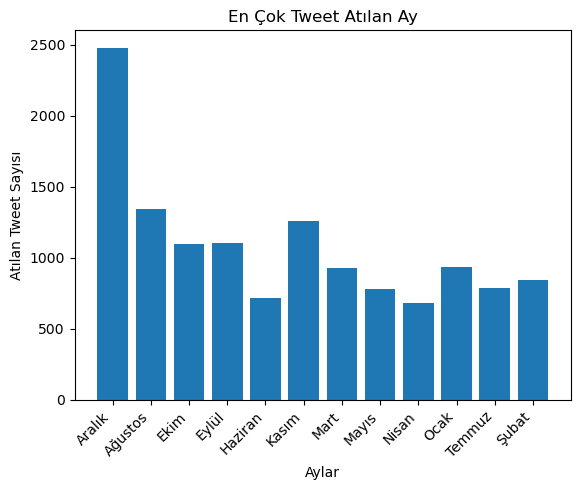

In [66]:
#plt.style.use("fivethirtyeight")
plt.bar(df_month["month"],df_month["count"])

plt.xticks(df_month["month"],rotation = 45, ha = "right")
plt.title("En Çok Tweet Atılan Ay")
plt.xlabel("Aylar")
plt.ylabel("Atılan Tweet Sayısı")
plt.show()

#### 7. How does the distribution of labels vary over time (date)?

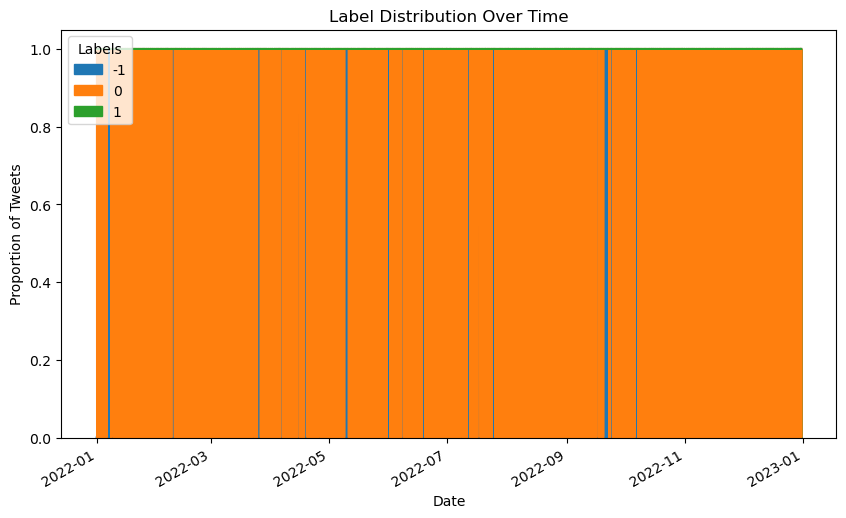

In [73]:
label_distribution = test_df.groupby("date")["label"].value_counts(normalize=True).unstack().fillna(0)

label_distribution.plot.area(stacked = True, figsize = (10, 6))
plt.title("Label Distribution Over Time")
plt.xlabel("Date")
plt.ylabel("Proportion of Tweets")
plt.legend(title = "Labels", loc = "upper left")
plt.show()

## Labeling train_df

This part is not concluded yet pass this for the time being

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 2)

## Model Training

Now in this part we will vectorize (process to turn words into vectors or rather numbers numbers because computer does not understand the words) our words then we will procced to build our ML algorithms.

In [75]:
from sklearn.model_selection import train_test_split
x_df, y_df = train_test_split(test_df, test_size=0.2, random_state=42)

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

In [77]:
train_texts = [' '.join(tokens) for tokens in test_df["tweet_token_clean"]]
test_texts = [' '.join(tokens) for tokens in test_df["tweet_token_clean"]]

train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)

### Support Vector Machines

SVM is a supervised machine learning algorithm used for classification tasks. It works by finding the optimal hyperplane that best separates the classes in the feature space. SVM aims to maximize the margin between the classes, which helps in generalization to unseen data. It is effective in high-dimensional spaces and can handle both linear and non-linear classification tasks through the use of different kernel functions. For this project we will use linear kernel

In [79]:
svm = SVC(kernel="linear")
t0 = time.time()
svm.fit(train_vectors,test_df["label"])
t1 = time.time()
predict = svm.predict(test_vectors)
t2 = time.time()

time_train = t1 - t0
time_predic = t2 - t1

In [80]:
print(f"Training Time : {time_train:.4f}")
print(f"Prediction Time : {time_predic:.4f}")
report = classification_report(test_df["label"], predict, output_dict=True)
class_1_metrics = report["1"]
class_0_metrics = report["0"]
class_n_metrics = report["-1"]
print(f"Metrics for Class 1: {class_1_metrics}")
print(f"Metrics for Class 0: {class_0_metrics}")
print(f"Metrics for Class -1: {class_n_metrics}")


accuracy = accuracy_score(test_df["label"], predict)
f1_score = classification_report(test_df["label"], predict, output_dict=True)["macro avg"]["f1-score"]
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Training Time : 11.5469
Prediction Time : 8.3982
Metrics for Class 1: {'precision': 0.8779342723004695, 'recall': 0.46546359676415683, 'f1-score': 0.6083773891825945, 'support': 1607.0}
Metrics for Class 0: {'precision': 0.776346936843102, 'recall': 0.9705255681818182, 'f1-score': 0.8626440107317587, 'support': 8448.0}
Metrics for Class -1: {'precision': 0.8751617076326003, 'recall': 0.4659090909090909, 'f1-score': 0.6080898876404495, 'support': 2904.0}
Accuracy: 0.7948
F1 Score: 0.6930


In [88]:
print(classification_report(test_df["label"], predict))

              precision    recall  f1-score   support

          -1       0.88      0.47      0.61      2904
           0       0.78      0.97      0.86      8448
           1       0.88      0.47      0.61      1607

    accuracy                           0.79     12959
   macro avg       0.84      0.63      0.69     12959
weighted avg       0.81      0.79      0.77     12959



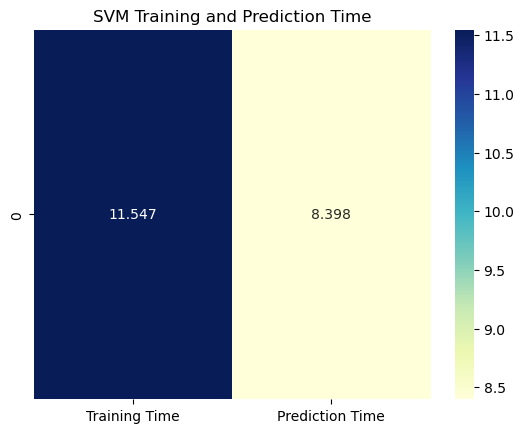

In [97]:
time_data = pd.DataFrame({
    "Training Time": [time_train],
    "Prediction Time": [time_predic]
})

sns.heatmap(time_data, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("SVM Training and Prediction Time")
plt.show()

In [92]:
def cleaning_text(text):
    text = text.lower()
    
    text = re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]', ' ', text)
    
    tokens = word_tokenize(text)
    

    stop_words = set(stopwords.words("turkish"))
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [word for word in tokens if len(word) > 1]
    
    cleaned_text = " ".join(tokens)
    
    return cleaned_text


print("please input a text to label")
text_svm = input()
cleaned_svm = cleaning_text(text_svm)
vectorized_svm = vectorizer.transform([cleaned_svm])
predict_svm = svm.predict(vectorized_svm)
print(f"Predicted Label : {predict_svm}")

please input a text to label
seni seviyorum
Predicted Label : [1]


### Random Forest

Random Forest is an ensemble learning method used for classification and regression tasks. It works by constructing multiple decision trees during training and outputting the mode of the classes (for classification) or the mean prediction (for regression) of the individual trees. Random Forest introduces randomness in the construction of each decision tree, both in terms of the data samples used for training and the features considered at each split. This randomness helps to reduce overfitting and improve the model's performance on unseen data. Random Forest is known for its robustness and ability to handle high-dimensional data with ease.

In [84]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
t3 = time.time()
rf.fit(train_vectors, test_df["label"])
t4 = time.time()
predict_rf = rf.predict(test_vectors)
t5 = time.time()

In [85]:
time_train_rf = t4 - t3
time_predict_rf = t5 - t4
print(f"Training Time : {time_train_rf:.4f}")
print(f"Prediction Time : {time_predict_rf:.4f}")
report = classification_report(test_df["label"], predict_rf, output_dict=True)
class_1_metrics = report["1"]
class_0_metrics = report["0"]
class_n_metrics = report["-1"]
print(f"Metrics for Class 1: {class_1_metrics}")
print(f"Metrics for Class 0: {class_0_metrics}")
print(f"Metrics for Class -1: {class_n_metrics}")



accuracy_rf = accuracy_score(test_df["label"], predict_rf)
f1_score_rf = classification_report(test_df["label"], predict_rf, output_dict=True)["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_score_rf:.4f}")

Training Time : 66.5480
Prediction Time : 1.6849
Metrics for Class 1: {'precision': 0.9893416927899686, 'recall': 0.9819539514623522, 'f1-score': 0.985633978763273, 'support': 1607.0}
Metrics for Class 0: {'precision': 0.9910482921083628, 'recall': 0.9959753787878788, 'f1-score': 0.9935057267682136, 'support': 8448.0}
Metrics for Class -1: {'precision': 0.9923451635351427, 'recall': 0.9820936639118457, 'f1-score': 0.9871928002769125, 'support': 2904.0}
Accuracy: 0.9911
F1 Score: 0.9888


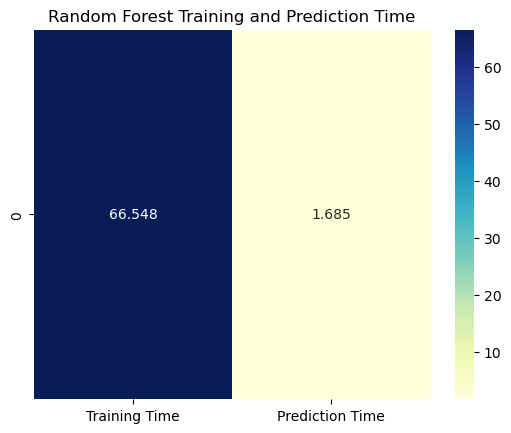

In [98]:
time_data_rf = pd.DataFrame({
    "Training Time": [time_train_rf],
    "Prediction Time": [time_predict_rf]
})

sns.heatmap(time_data_rf, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Random Forest Training and Prediction Time")
plt.show()

In [90]:
print("please input a text to label")
text_rf = input()
cleaned_rf = cleaning_text(text_rf)
vectorized_rf = vectorizer.transform([cleaned_rf])
predict_rf = rf.predict(vectorized_rf)
print(f"Predicted Label : {predict_rf}")

please input a text to label
senden nefret ediyorum
Predicted Label : [-1]


## Cleaning Function

This fuction does the entire cleaning process

In [94]:
def cleaning_text(text):
    text = text.lower()
    
    text = re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]', ' ', text)
    
    tokens = word_tokenize(text)
    

    stop_words = set(stopwords.words("turkish"))
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [word for word in tokens if len(word) > 1]
    
    cleaned_text = " ".join(tokens)
    
    return cleaned_text


print("please input a text to label")
text_clean = input()
print(cleaning_text(text_clean))

please input a text to label
KÖPRÜDEN ;;; ,,, Geçti gelin......
köprüden geçti gelin
